# Marmousi (original) model

In [6]:
import os
from pathlib import Path
import segyio
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1
import numpy as np

import urllib.request

http://www.reproducibility.org/RSF/book/data/marmousi/paper.pdf

## Get the data

In [74]:
!pwd

/work/bfilippo/cervino/notebooks


In [101]:
dirname = 'marmousi_original_model'
filename = 'marmousi_archive.tar.gz'
filename_h5 = '/'.join((dirname, 'marmousi_original.h5'))
filename_prefix = '/'.join((dirname, 'marmousi_original'))

In [76]:
result = urllib.request.urlretrieve('http://trip.rice.edu/downloads/ieee.tar.gz', filename)

In [77]:
import tarfile
tarfile.open(filename, mode='r:gz').extractall()
os.rename('ieee', dirname)

In [103]:
tarfile.open(filename, mode='r:gz').list()

?rwxr-xr-x symes/mascfac          0 2005-11-28 01:38:03 ieee/ 
?rw-r--r-- symes/mascfac   74653200 1998-04-07 02:11:30 ieee/data.segy 
?rw-r--r-- symes/mascfac    7096044 1991-09-12 21:23:36 ieee/density.segy 
?rw-r--r-- symes/mascfac    7096044 1991-09-11 19:36:44 ieee/velocity.segy 
?rw-r--r-- symes/mascfac       1350 2005-11-28 01:37:15 ieee/README 


In [80]:
!ls marmousi_original_model

data.segy  density.segy  README  velocity.segy


In [81]:
path = Path(dirname)
print(path.resolve())

/work/bfilippo/cervino/notebooks/marmousi_original_model


## Load the data

In [82]:
for i in path.glob('*.segy'):
    print(i)

marmousi_original_model/data.segy
marmousi_original_model/density.segy
marmousi_original_model/velocity.segy


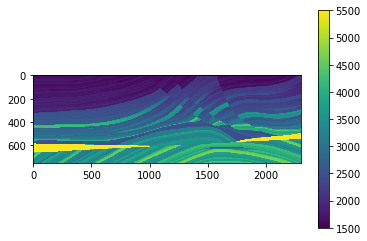

In [83]:
# Fix the header - Wrong format
with segyio.open('marmousi_original_model/velocity.segy', mode = 'r+', ignore_geometry=True) as f:
    f.bin[segyio.su.format] = 5

# with segyio.open('marmousi_original_model/velocity.segy', mode = 'r+', ignore_geometry=True) as f:
#     data = f.trace.raw[:]
    
#     im = plt.imshow(data)
#     plt.colorbar(im)

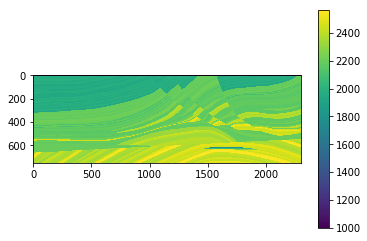

In [84]:
# Fix the header - Wrong format
with segyio.open('marmousi_original_model/density.segy', mode = 'r+', ignore_geometry=True) as f:
    f.bin[segyio.su.format] = 5

# with segyio.open('marmousi_original_model/density.segy', mode = 'r+', ignore_geometry=True) as f:
#     data = f.trace.raw[:]
    
#     im = plt.imshow(data)
#     plt.colorbar(im)

In [92]:
file_list = ['/'.join((dirname, 'velocity.segy')),
             '/'.join((dirname, 'density.segy'))]

model_list = {'vp': 'm/s',
              'rho': 'kg/m^3'}

# Create HDF5 file
with h5py.File(filename_h5, 'w') as f:
    model_group = f.create_group('Models')

    for file, model  in zip(file_list, model_list.keys()):
        print(file)
        
        data = segyio.open(file, ignore_geometry=True).trace.raw[:].T
        model_group.create_dataset(model, data=data)
    
    # Create geometry group
    geometry_group = f.create_group('Geometry')
    geometry_group.attrs['number-of-cells'] = [2301, 1, 751]
    geometry_group.attrs['cell-size'] = [4., 4., 4.]
    geometry_group.attrs['origin'] = [0.0, 0.0, 0.0]

marmousi_original_model/velocity.segy
marmousi_original_model/density.segy


In [93]:
with h5py.File(filename_h5, 'r') as f:
    print(f['Geometry'].attrs['cell-size'])
    print(type(f['Geometry'].attrs['cell-size']))

[4. 4. 4.]
<class 'numpy.ndarray'>


## Create binary files for Matterhorn

In [94]:
with h5py.File(filename_h5, 'r') as f:
    dset = f['Models']['vp']
    with dset.astype('float32'):
        print(dset.shape)
        dset[:].tofile('{}_{}'.format(filename_prefix, 'vp.bin'))
    dset = f['Models']['rho']
    with dset.astype('float32'):
        print(dset.shape)
        dset[:].tofile('{}_{}'.format(filename_prefix, 'rho.bin'))

(2301, 751)
(2301, 751)


## Plot models

In [96]:
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

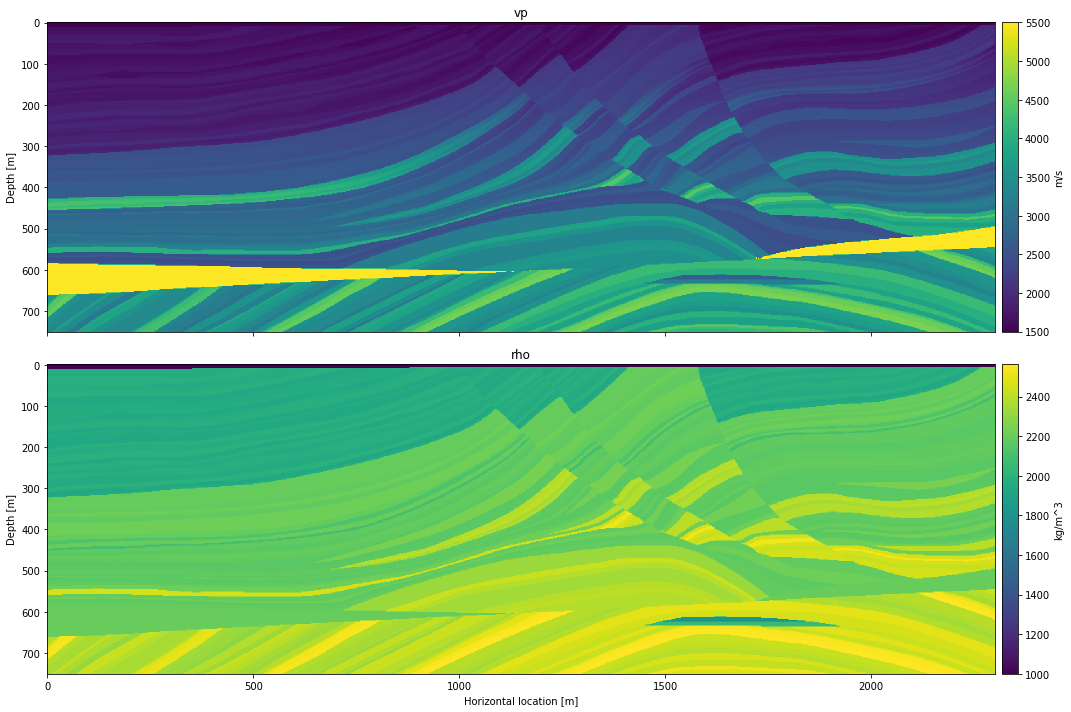

In [98]:
# Set up figure
clip = 1e-1
vmin, vmax = -clip, clip

# Figure
figsize=(15, 10)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize, facecolor='w', edgecolor='k',
                        squeeze=False,
                        sharex=True)
axs = axs.ravel()
# fig.set_figwidth(20)

im = []
with h5py.File(filename_h5, 'r') as f:
    for i, (model, unit) in enumerate(model_list.items()):
        im.append(axs[i].imshow(f['Models'][model][()].T, cmap=plt.cm.viridis, aspect=1))
        _ = axs[i].set_title(model)
#         _ = axs[i].set_xlabel('Horizontal location [m]')
        _ = axs[i].set_ylabel('Depth [m]')
        cb = add_colorbar(im[i])
        cb.set_label(unit)
#     _ = axs[0].set_xlabel('Depth [m]')
    _ = axs[1].set_xlabel('Horizontal location [m]')
fig.tight_layout()